In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

/Users/michal/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('../data/fer2013/fer2013.csv')
df.sample(5)

,emotion,pixels,Usage
15560,3,73 72 94 190 184 185 241 253 232 224 245 255 1...,Training
22580,5,255 255 255 254 255 200 141 120 114 113 87 65 ...,Training
19506,4,255 255 255 255 254 255 253 250 254 138 51 49 ...,Training
10337,5,186 74 78 70 70 76 72 64 62 61 61 70 86 118 12...,Training
9180,3,170 175 123 64 88 111 104 88 73 88 113 169 197...,Training


In [3]:
def error_rate(pred, target):
    return np.mean(pred!=target)

In [4]:
def classification_rate(p, t):
    return np.mean(p == t)

In [5]:
def ohe(labels):
    ohe_lab = np.zeros((labels.shape[0], len(set(labels))))
    for i in range(len(labels)):
        ohe_lab[i, labels[i]] = 1
    return ohe_lab     

In [6]:
Y_all = df['emotion'].astype(int)
X_all = []
for i in df['pixels']:
    X_all.append([int(p) for p in i.split()])
X_all, Y_all = np.array(X_all), np.array(Y_all)

In [7]:
X = X_all / 255
Y = ohe(Y_all)

In [8]:
print(X.shape)
print(type(X))
print(Y.shape)
print(type(Y))

(35887, 2304)
<class 'numpy.ndarray'>
(35887, 7)
<class 'numpy.ndarray'>


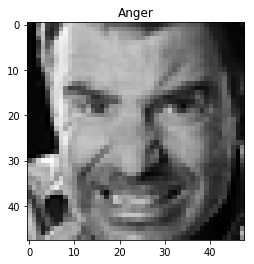

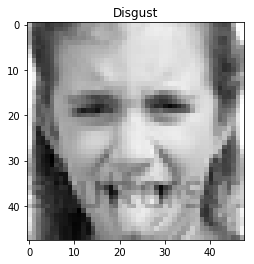

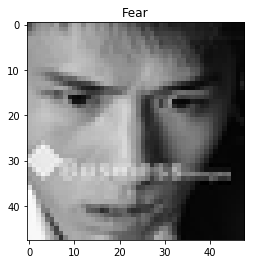

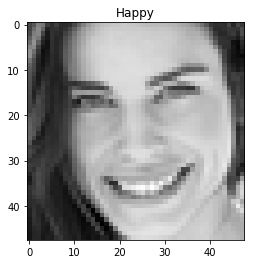

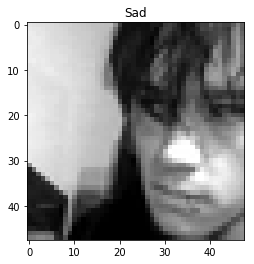

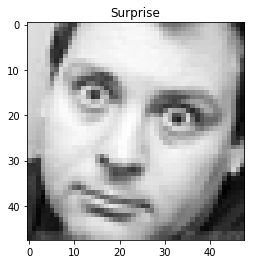

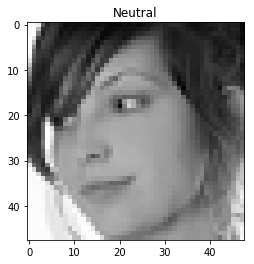

In [9]:
# show one of each emtion randomly
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

for i in range(7):
    x, y = X_all[Y_all==i], Y_all[Y_all==i]
    N = len(y)
    j = np.random.choice(N)
    plt.imshow(x[j].reshape(48,48), cmap='gray')
    plt.title(label_map[y[j]])
    plt.show()

In [10]:
max_iter = 50
print_period = 20
lr = 1e-5
reg = 1e-2

In [11]:
X_train = X[:-1000]
Y_train = Y[:-1000]
X_test = X[-1000:]
Y_test = Y[-1000:]

In [12]:
N, D = X_train.shape
batch_size = 100
num_batches = N//batch_size

In [13]:
# hidden layer1 nodes
M1 = 2000
# hidden layer2 nodes
M2 = 1000
# hidden layer3 nodes
M3 = 500
# output nodes
K = 7
# starting wieghts
W1_init = np.random.randn(D, M1) / np.sqrt(D+M1)
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1+M2)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, M3) / np.sqrt(M2+M3)
b3_init = np.zeros(M3)
W4_init = np.random.randn(M3, K) / np.sqrt(M3+K)
b4_init = np.zeros(K)

In [14]:
# get TF variables for the inputs, X and targets T
ftX = tf.placeholder(tf.float32, shape=(None, D), name='X')
ftT = tf.placeholder(tf.float32, shape=(None, K), name='T')

In [15]:
# get TF variables wieghts and biases
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

In [16]:
Z1 = tf.nn.relu(tf.matmul(ftX, W1)+b1)
Z2 = tf.nn.relu(tf.matmul(Z1, W2)+b2)
Z3 = tf.nn.relu(tf.matmul(Z2, W3)+b3)
Yish = tf.matmul(Z3, W4)+b4

In [17]:
# params = list of weights and biases
# rcost = reg*sum([tf.nn.l2_loss(p) for p in params])
rcost = reg*sum([tf.nn.l2_loss(W1), tf.nn.l2_loss(b1), 
                 tf.nn.l2_loss(W2), tf.nn.l2_loss(b2), 
                 tf.nn.l2_loss(W3), tf.nn.l2_loss(b3),
                 tf.nn.l2_loss(W4), tf.nn.l2_loss(b4)])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    labels=ftT, logits=Yish)) + rcost

In [18]:
pred = tf.argmax(Yish, 1)

In [19]:
train_op = tf.train.RMSPropOptimizer(lr, decay=0.999, momentum=0.99).minimize(cost)

In [20]:
LL = []
error = []
accuracy = []
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(max_iter):
        X_train, Y_train = shuffle(X_train, Y_train)
        for j in range(num_batches):
            X_batch = X_train[(j*batch_size):(j*batch_size+batch_size)]
            Y_batch = Y_train[(j*batch_size):(j*batch_size+batch_size)]
        
            sess.run(train_op, feed_dict = {ftX: X_batch, ftT: Y_batch})
            if j % print_period == 0:
                cost_val = sess.run(cost, feed_dict={ftX: X_test, ftT: Y_test})
                pred_val = sess.run(pred, feed_dict={ftX: X_test})
                err = error_rate(pred_val, Y_test.argmax(axis = 1))
                acc = classification_rate(pred_val, Y_test.argmax(axis = 1))
                print(i,j,cost_val,err)
                LL.append(cost_val)
                error.append(err)
                accuracy.append(acc)

0 0 12.315361 0.827
0 20 12.31305 0.826
0 40 12.307331 0.825
0 60 12.299093 0.824
0 80 12.28941 0.809
0 100 12.279039 0.791
0 120 12.26862 0.785
0 140 12.258617 0.781
0 160 12.249223 0.78
0 180 12.240364 0.78
0 200 12.231895 0.78
0 220 12.223856 0.78
0 240 12.216018 0.78
0 260 12.20843 0.78
0 280 12.201073 0.78
0 300 12.193899 0.78
0 320 12.186887 0.78
0 340 12.179804 0.78
1 0 12.177041 0.78
1 20 12.170319 0.78
1 40 12.163732 0.78
1 60 12.156989 0.78
1 80 12.150251 0.78
1 100 12.143648 0.78
1 120 12.137093 0.78
1 140 12.130644 0.78
1 160 12.124401 0.78
1 180 12.118137 0.78
1 200 12.1120205 0.78
1 220 12.105995 0.78
1 240 12.100037 0.78
1 260 12.094101 0.78
1 280 12.088018 0.78
1 300 12.081797 0.78
1 320 12.075569 0.78
1 340 12.06942 0.78
2 0 12.066969 0.78
2 20 12.060792 0.78
2 40 12.054538 0.78
2 60 12.048254 0.78
2 80 12.041843 0.78
2 100 12.03548 0.78
2 120 12.029158 0.78
2 140 12.023011 0.78
2 160 12.016976 0.78
2 180 12.011045 0.78
2 200 12.005146 0.78
2 220 11.998956 0.78
2 240 1

21 60 3.9927902 0.627
21 80 3.9557164 0.623
21 100 3.9489295 0.639
21 120 3.9002526 0.649
21 140 3.8720264 0.633
21 160 3.8308358 0.636
21 180 3.8708596 0.677
21 200 3.775371 0.658
21 220 3.7366433 0.63
21 240 3.6947365 0.658
21 260 3.6538785 0.635
21 280 3.6161666 0.645
21 300 3.5956004 0.624
21 320 3.5395803 0.632
21 340 3.5447688 0.646
22 0 3.4934638 0.615
22 20 3.463488 0.63
22 40 3.4277844 0.637
22 60 3.40354 0.627
22 80 3.377852 0.635
22 100 3.327754 0.633
22 120 3.338006 0.649
22 140 3.2969446 0.661
22 160 3.2591133 0.635
22 180 3.2232795 0.639
22 200 3.1735663 0.633
22 220 3.1806006 0.637
22 240 3.1341136 0.638
22 260 3.0837333 0.627
22 280 3.0685103 0.626
22 300 3.0500302 0.651
22 320 3.021845 0.627
22 340 3.0086656 0.648
23 0 2.9939103 0.633
23 20 2.973806 0.663
23 40 2.923204 0.63
23 60 2.8912296 0.632
23 80 2.8545732 0.634
23 100 2.8274446 0.62
23 120 2.8061712 0.63
23 140 2.813387 0.638
23 160 2.7918162 0.659
23 180 2.7649994 0.639
23 200 2.711269 0.624
23 220 2.731391 0.6

41 200 1.7339584 0.675
41 220 1.7329218 0.669
41 240 1.7499479 0.672
41 260 1.7281259 0.666
41 280 1.7272904 0.654
41 300 1.7324251 0.664
41 320 1.7818958 0.704
41 340 1.7228523 0.652
42 0 1.7633916 0.682
42 20 1.7191586 0.654
42 40 1.7264264 0.648
42 60 1.7395612 0.675
42 80 1.7279829 0.66
42 100 1.732871 0.658
42 120 1.7417002 0.674
42 140 1.7465546 0.647
42 160 1.7280985 0.672
42 180 1.7398531 0.67
42 200 1.7362895 0.654
42 220 1.7439766 0.681
42 240 1.7351618 0.67
42 260 1.7275141 0.664
42 280 1.737626 0.644
42 300 1.7788037 0.688
42 320 1.7382182 0.689
42 340 1.7217621 0.636
43 0 1.7619486 0.676
43 20 1.7455491 0.661
43 40 1.7362294 0.66
43 60 1.7598325 0.692
43 80 1.7338694 0.667
43 100 1.7515898 0.683
43 120 1.7556365 0.669
43 140 1.7320327 0.662
43 160 1.7364725 0.675
43 180 1.7309899 0.656
43 200 1.7378803 0.674
43 220 1.7347904 0.666
43 240 1.7272257 0.645
43 260 1.7218009 0.657
43 280 1.7256333 0.652
43 300 1.7238437 0.644
43 320 1.7322143 0.668
43 340 1.7389876 0.668
44 0 1

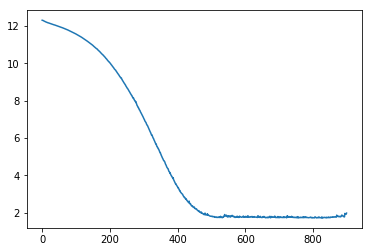

In [21]:
plt.plot(LL)
plt.show()

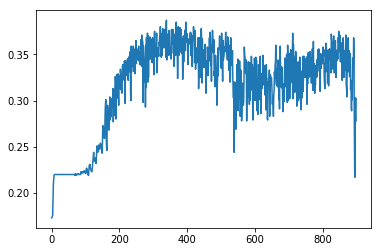

In [22]:
plt.plot(accuracy)
plt.show()